In [4]:
# Herramientas para EDA
import pandas as pd
import numpy as np
import sidetable as stb
from datetime import timedelta
from datetime import date, datetime
import random 

# Herramientas para la Visualización
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.gridspec import GridSpec

# Transformación de datos

from scipy import stats
import math 
from sklearn.preprocessing import MinMaxScaler

# Estadísticos
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import skew
from scipy.stats import kurtosistest
from scipy import stats
from scipy.stats import kstest

plt.rcParams["figure.figsize"] = (16,8)

import warnings
warnings.filterwarnings('ignore')

In [5]:
cd2=pd.read_csv('../archivos/bikes_stand.csv', index_col=0)
cd2.head(20)

,fecha,estacion,año,mes,dia_semana,dias_festivos,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis
0,2018-01-01,invierno,0,1,lunes,New Year's Day,-0.486274,0.855582,-0.208909,331,654,985
1,2018-01-02,invierno,0,1,martes,No Festivo,-0.425690,0.332722,0.687550,131,670,801
2,2018-01-03,invierno,0,1,miercoles,No Festivo,-0.949970,-0.900337,0.685210,120,1229,1349
3,2018-01-04,invierno,0,1,jueves,No Festivo,-0.938563,-0.170632,-0.210435,108,1454,1562
4,2018-01-05,invierno,0,1,viernes,No Festivo,-0.853992,-0.901843,0.060294,82,1518,1600
5,2018-01-06,invierno,0,1,sabado,No Festivo,-0.924922,-0.514489,-0.930212,88,1518,1606
6,2018-01-07,invierno,0,1,domingo,No Festivo,-0.949474,-0.607702,-0.124649,148,1362,1510
7,2018-01-08,invierno,0,1,lunes,No Festivo,-1.048367,-0.430771,0.873420,68,891,959
8,2018-01-09,invierno,0,1,martes,No Festivo,-1.132028,-0.915135,1.841652,54,768,822
9,2018-01-10,invierno,0,1,miercoles,No Festivo,-1.092813,-0.682877,0.430375,41,1280,1321


In [6]:
cd2.describe()

,año,mes,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis
count,730.000000,730.000000,7.300000e+02,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,6.526027,-1.121511e-02,0.006678,0.096947,849.249315,3658.757534,4508.006849
std,0.500343,3.450215,5.744039e-01,0.678317,0.789169,686.479875,1559.758728,1936.011647
min,0.000000,1.000000,-1.380508e+00,-2.983624,-1.613788,2.000000,20.000000,22.000000
25%,0.000000,4.000000,-5.091498e-01,-0.506204,-0.468363,316.250000,2502.250000,3169.750000
50%,0.500000,7.000000,1.500536e-16,0.000000,0.000000,717.000000,3664.500000,4548.500000
75%,1.000000,10.000000,4.908502e-01,0.493796,0.531637,1096.500000,4783.250000,5966.000000
max,1.000000,12.000000,1.137258e+00,1.649628,3.322433,3410.000000,6946.000000,8714.000000


In [7]:
cd2.loc[cd2['total_bicis']==8714]

,fecha,estacion,año,mes,dia_semana,dias_festivos,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis
622,2019-09-15,verano,1,9,domingo,No Festivo,0.342484,-0.593547,0.677191,3160,5554,8714


>3 festivales de musica, uno de caminar por la ciudad y  **reabre el monumento de Washinton**.

In [8]:
cd2.loc[cd2['dias_festivos']!='No Festivo']

,fecha,estacion,año,mes,dia_semana,dias_festivos,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis
0,2018-01-01,invierno,0,1,lunes,New Year's Day,-0.486274,0.855582,-0.208909,331,654,985
14,2018-01-15,invierno,0,1,lunes,Martin Luther King Jr. Day,-0.833989,-0.607444,-0.234177,222,1026,1248
49,2018-02-19,invierno,0,2,lunes,Washington's Birthday,-0.313724,-2.088337,3.322433,532,1103,1635
147,2018-05-28,primavera,0,5,lunes,Memorial Day,0.491504,0.492306,0.499828,2001,2757,4758
184,2018-07-04,verano,0,7,miercoles,Independence Day,0.713728,0.055585,-1.012497,3065,2978,6043
245,2018-09-03,verano,0,9,lunes,Labor Day,0.533336,0.430771,0.044267,1935,2549,4484
280,2018-10-08,otoño,0,10,lunes,Columbus Day,0.070590,0.357320,-1.379606,2235,3174,5409
314,2018-11-11,otoño,0,11,domingo,Veterans Day,-0.549019,-0.857569,1.360568,440,2928,3368
315,2018-11-12,otoño,0,11,lunes,Veterans Day (Observed),-0.447058,-0.349378,0.316350,1275,2792,4067
325,2018-11-22,otoño,0,11,jueves,Thanksgiving,-0.258822,1.601986,-0.632792,69,1538,1607


## Esta gente se mueve mas en bici para las fiestas más patrióticas, igual que con la reapertura del monumento a Washinton

In [9]:
cd2.skew()

año                     0.000000
mes                    -0.010478
temperatura            -0.057187
humedad                -0.067476
velocidad_viento        0.676314
clientes_casuales       1.266328
clientes_registrados    0.041211
total_bicis            -0.049581
dtype: float64

Probamos si podemos normalizar los totales parciales (registrados y casuales, pero nada)

In [10]:
#cd2["clientes_registrados_norm"] = cd2["clientes_registrados"].apply(lambda x: math.sqrt(x))

In [11]:
##stats.shapiro(cd2["clientes_registrados_norm"])

ShapiroResult(statistic=0.9734106659889221, pvalue=2.97543378824372e-10)

In [12]:
#cd2["total_bicis_norm"] = cd2["total_bicis"].apply(lambda x: math.sqrt(x))

In [13]:
#stats.shapiro(cd2["total_bicis_norm"])

ShapiroResult(statistic=0.9646831154823303, pvalue=2.879613214545884e-12)

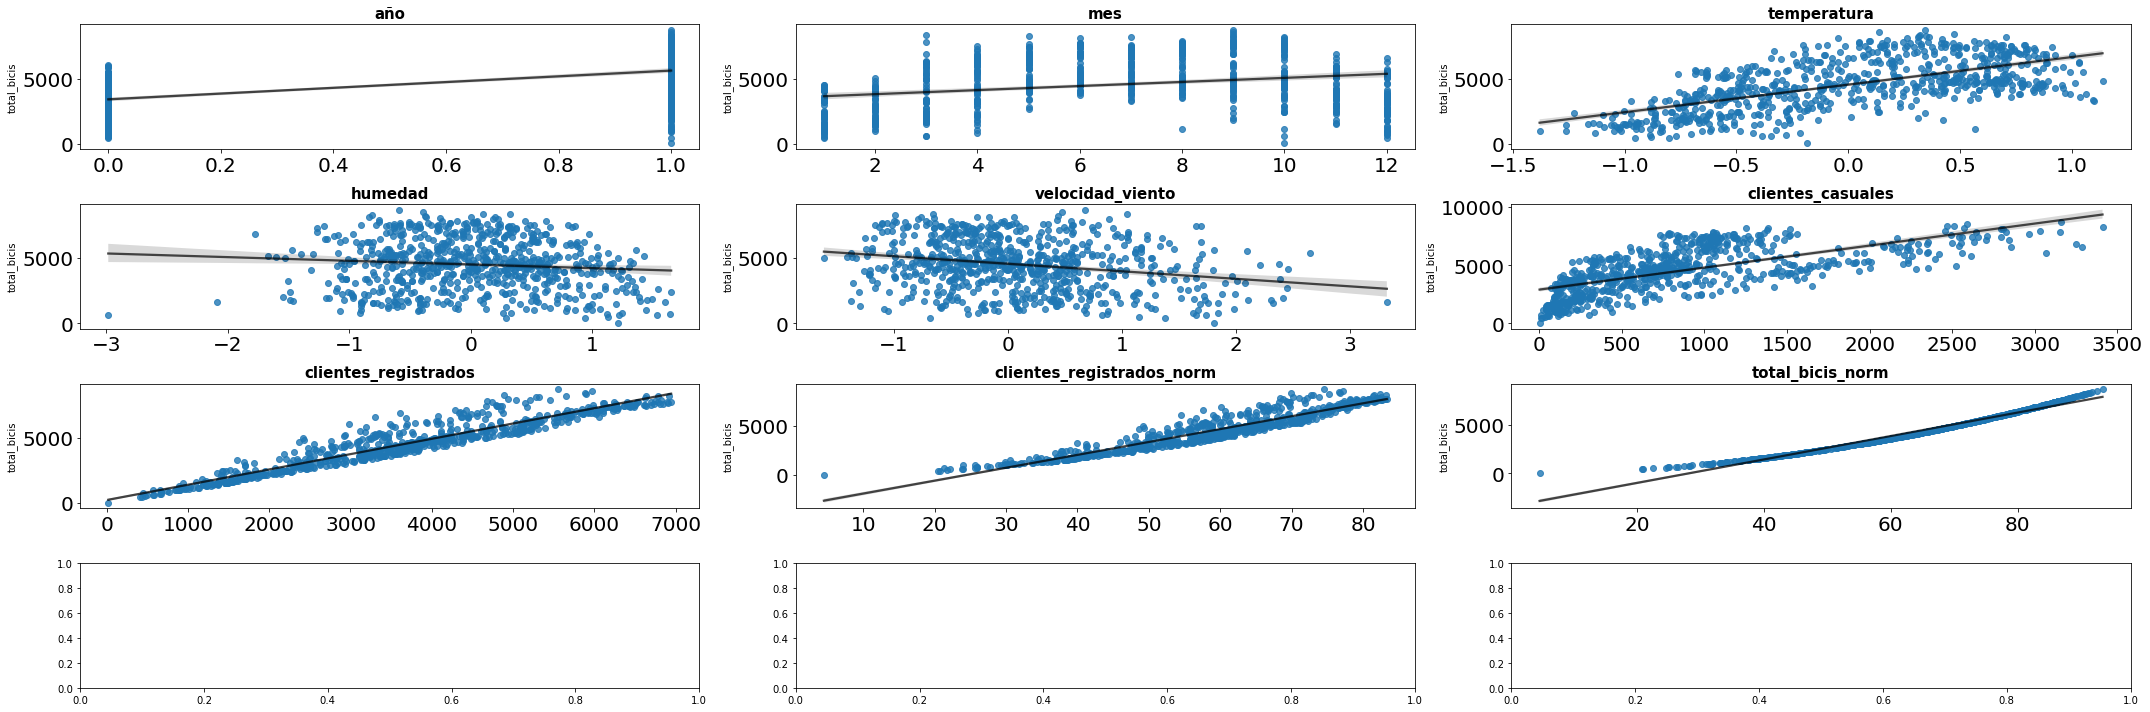

In [14]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (30, 10))

# definimos una lista de colores. Cada color corresponderá a una gráfica
lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange"]

# hemos creado una gráfica con varios subplots. Si queremos automatizar el proceso de relleno de cada uno de los plots
## podemos usar el método .flat. Lo que hace es aplanar los ejes para que queden en una única dimensión
## y luego los vamos rellenando. 
axes = axes.flat

# seleccionamos las columnas que queremos graficar
columnas_numeric = cd2.select_dtypes(include = np.number).drop('total_bicis', axis=1)
columnas_numeric = columnas_numeric.columns

# iniciamos un for loop para no tener que escribir la misma línea de código muchas veces
for i, colum in enumerate(columnas_numeric): 
    sns.regplot(
        data = cd2,
        x = colum,
        y = 'total_bicis',
        #color = lista_colores[i],
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])
    
    # establecemos el título de cada gráfica
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")

    # establacemos el tamaño de la letras de los ejes
    axes[i].tick_params(labelsize = 20)

    # establecemos que no queremos que aparezca nada en el eje x
    axes[i].set_xlabel("")
    
# ajustamos el tamaño de cada subplot para que no se vean superpuestos. 
fig.tight_layout();

<AxesSubplot:>

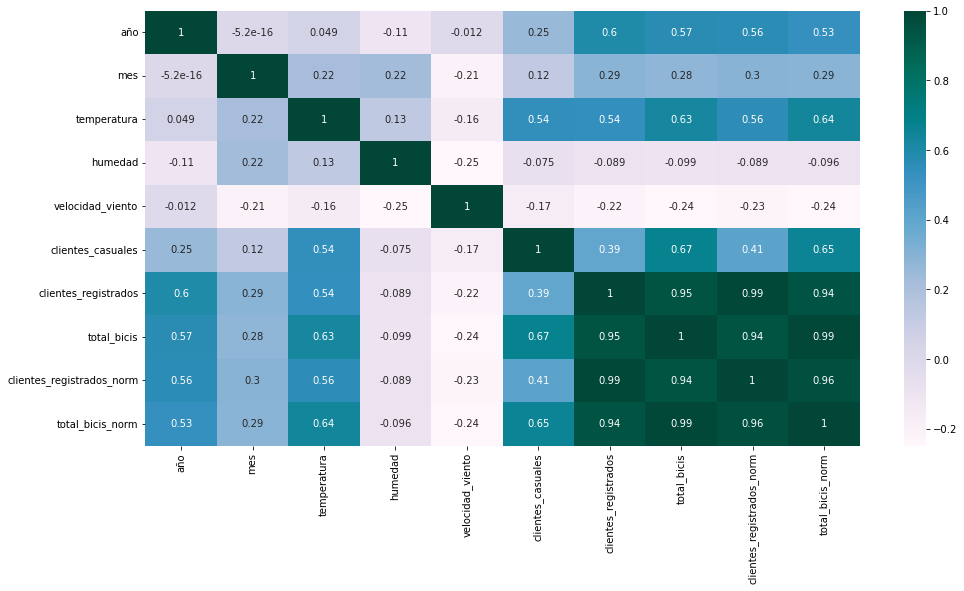

In [15]:
sns.heatmap(cd2.corr(), cmap= 'PuBuGn', annot= True)

In [16]:
cd2['dia_semana'].value_counts()

lunes        105
martes       105
miercoles    104
jueves       104
viernes      104
sabado       104
domingo      104
Name: dia_semana, dtype: int64

In [17]:
df_sabdo=cd2[(cd2['dia_semana']=='sabado')]

<AxesSubplot:>

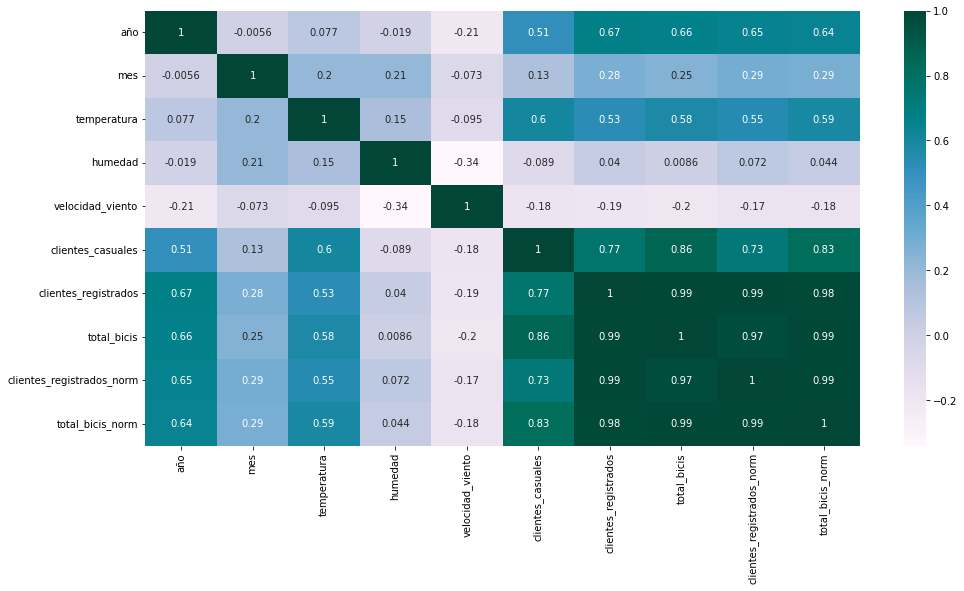

In [18]:
sns.heatmap(df_sabdo.corr(), cmap= 'PuBuGn', annot= True)

La correlacion entre casuales y bicis, aumenta por encima de 0.7 para dias festivos incluyendo sabados

A la vista de ls correlaciones del sabado, lo incluimos dentro de no laborables, sigue una distribucion más parecida a esa condicion

In [19]:
df_no_laborables=cd2[(cd2['dias_festivos']!='No Festivo')|(cd2['dia_semana']=='domingo')|(cd2['dia_semana']=='sabado')]
df_no_laborables.head()

,fecha,estacion,año,mes,dia_semana,dias_festivos,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis,clientes_registrados_norm,total_bicis_norm
0,2018-01-01,invierno,0,1,lunes,New Year's Day,-0.486274,0.855582,-0.208909,331,654,985,25.573424,31.384710
5,2018-01-06,invierno,0,1,sabado,No Festivo,-0.924922,-0.514489,-0.930212,88,1518,1606,38.961519,40.074930
6,2018-01-07,invierno,0,1,domingo,No Festivo,-0.949474,-0.607702,-0.124649,148,1362,1510,36.905284,38.858718
12,2018-01-13,invierno,0,1,sabado,No Festivo,-1.048367,-0.742430,1.221408,38,1368,1406,36.986484,37.496667
13,2018-01-14,invierno,0,1,domingo,No Festivo,-1.061324,-0.421276,-0.553864,54,1367,1421,36.972963,37.696154


In [20]:
df_no_laborables.describe()

,año,mes,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis,clientes_registrados_norm,total_bicis_norm
count,228.0000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,0.5000,6.605263,-0.018701,-0.034173,0.096569,963.850877,3618.964912,4582.815789,58.785616,65.826164
std,0.5011,3.516151,0.574217,0.687789,0.765917,846.841535,1413.937919,1999.779640,12.803721,15.837679
min,0.0000,1.000000,-1.113158,-2.983624,-1.613788,15.000000,416.000000,431.000000,20.396078,20.760539
25%,0.0000,3.750000,-0.498038,-0.484865,-0.449364,269.000000,2783.250000,3232.750000,52.756320,56.857198
50%,0.5000,7.000000,-0.067973,-0.009926,0.018953,735.500000,3720.500000,4572.000000,60.995895,67.616562
75%,1.0000,10.000000,0.489544,0.429281,0.510099,1320.500000,4559.750000,6045.500000,67.525920,77.752808
max,1.0000,12.000000,1.137258,1.649628,3.322433,3410.000000,6917.000000,8714.000000,83.168504,93.348808


In [21]:
df_laborables2=cd2[(cd2['dias_festivos']=='No Festivo')]#|(cd['dia_semana']!='domingo')|((cd['dia_semana']!='sabado'))]
df_laborables2.head()

,fecha,estacion,año,mes,dia_semana,dias_festivos,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis,clientes_registrados_norm,total_bicis_norm
1,2018-01-02,invierno,0,1,martes,No Festivo,-0.425690,0.332722,0.687550,131,670,801,25.884358,28.301943
2,2018-01-03,invierno,0,1,miercoles,No Festivo,-0.949970,-0.900337,0.685210,120,1229,1349,35.057096,36.728735
3,2018-01-04,invierno,0,1,jueves,No Festivo,-0.938563,-0.170632,-0.210435,108,1454,1562,38.131352,39.522146
4,2018-01-05,invierno,0,1,viernes,No Festivo,-0.853992,-0.901843,0.060294,82,1518,1600,38.961519,40.000000
5,2018-01-06,invierno,0,1,sabado,No Festivo,-0.924922,-0.514489,-0.930212,88,1518,1606,38.961519,40.074930


In [22]:
df_laborables2.dia_semana.value_counts()

viernes      104
sabado       104
martes       103
domingo      103
miercoles    102
jueves       101
lunes         92
Name: dia_semana, dtype: int64

Volvemos a incluir sabados en festivos en base a las correlaciones con total bicis

In [23]:
df_laborables=df_laborables2[(df_laborables2['dia_semana']=='lunes')|(df_laborables2['dia_semana']=='martes')|(df_laborables2['dia_semana']=='miercoles')|(df_laborables2['dia_semana']=='jueves')|(df_laborables2['dia_semana']=='viernes')]
df_laborables.head()

,fecha,estacion,año,mes,dia_semana,dias_festivos,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis,clientes_registrados_norm,total_bicis_norm
1,2018-01-02,invierno,0,1,martes,No Festivo,-0.425690,0.332722,0.687550,131,670,801,25.884358,28.301943
2,2018-01-03,invierno,0,1,miercoles,No Festivo,-0.949970,-0.900337,0.685210,120,1229,1349,35.057096,36.728735
3,2018-01-04,invierno,0,1,jueves,No Festivo,-0.938563,-0.170632,-0.210435,108,1454,1562,38.131352,39.522146
4,2018-01-05,invierno,0,1,viernes,No Festivo,-0.853992,-0.901843,0.060294,82,1518,1600,38.961519,40.000000
7,2018-01-08,invierno,0,1,lunes,No Festivo,-1.048367,-0.430771,0.873420,68,891,959,29.849623,30.967725


In [24]:
df_laborables.dia_semana.value_counts()

viernes      104
martes       103
miercoles    102
jueves       101
lunes         92
Name: dia_semana, dtype: int64

In [25]:
df_laborables['total_bicis'].sum()

2245963

In [26]:
df_no_laborables['total_bicis'].sum()

1044882

In [27]:
df_laborables.describe()

,año,mes,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis,clientes_registrados_norm,total_bicis_norm
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,0.500000,6.490040,-0.007815,0.025232,0.097119,797.199203,3676.830677,4474.029880,58.901042,65.020014
std,0.500499,3.422787,0.575029,0.673844,0.800259,593.375331,1622.691903,1907.407263,14.419158,15.713674
min,0.000000,1.000000,-1.380508,-1.669481,-1.411153,2.000000,20.000000,22.000000,4.472136,4.690416
25%,0.000000,4.000000,-0.513072,-0.511662,-0.480870,325.250000,2456.500000,3115.500000,49.563072,55.816664
50%,0.500000,6.500000,0.020915,0.007942,-0.009500,711.500000,3633.000000,4544.500000,60.274372,67.412902
75%,1.000000,9.000000,0.490850,0.516128,0.543856,1053.500000,4986.250000,5914.750000,70.613369,76.907403
max,1.000000,12.000000,1.098043,1.639704,2.651816,2846.000000,6946.000000,8227.000000,83.342666,90.702811


<AxesSubplot:>

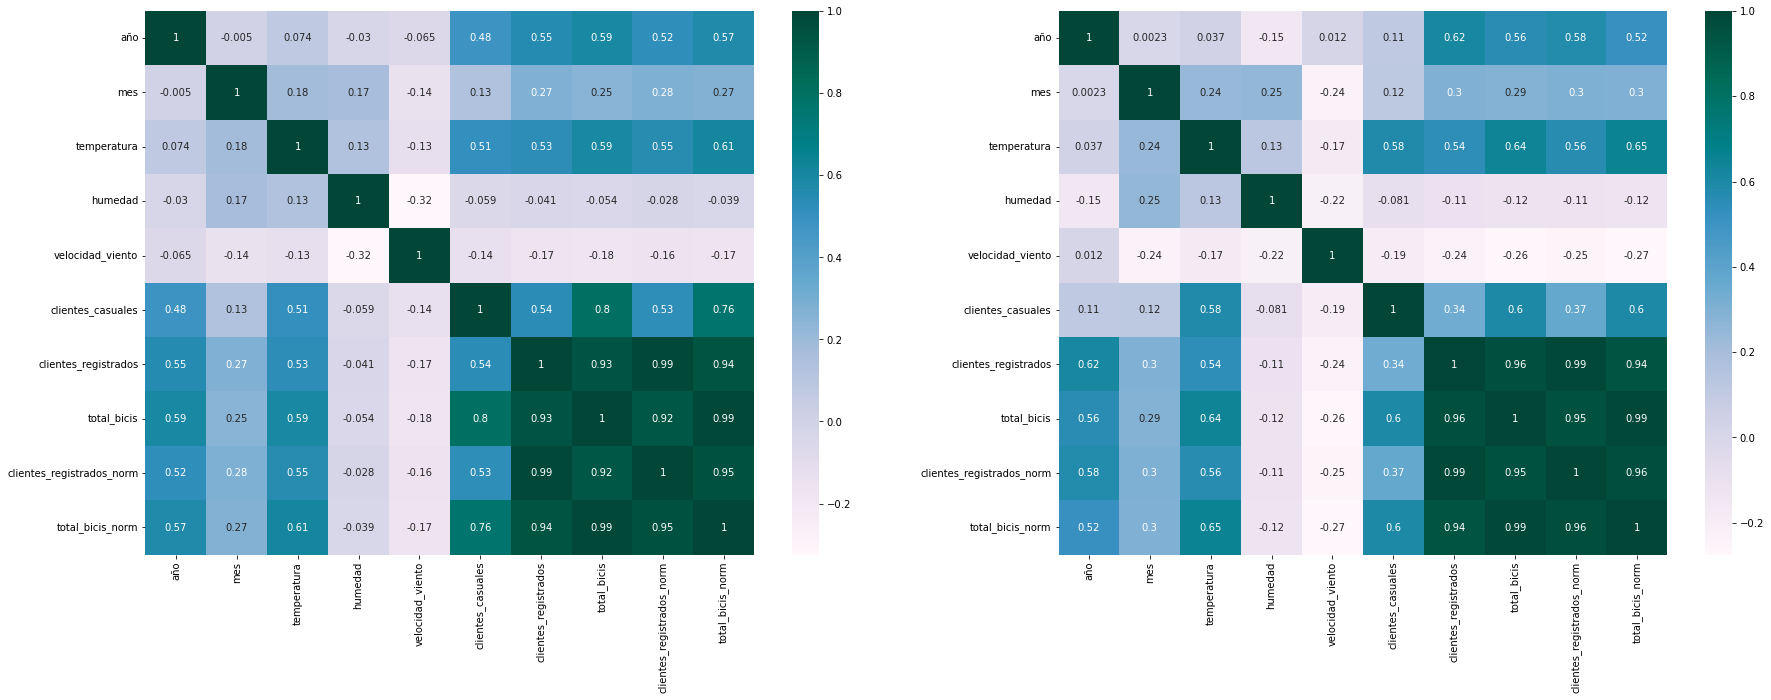

In [28]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))
sns.heatmap(df_no_laborables.corr(), cmap= 'PuBuGn', annot= True, ax=axes[0])
sns.heatmap(df_laborables.corr(), cmap= 'PuBuGn', annot= True, ax=axes[1])

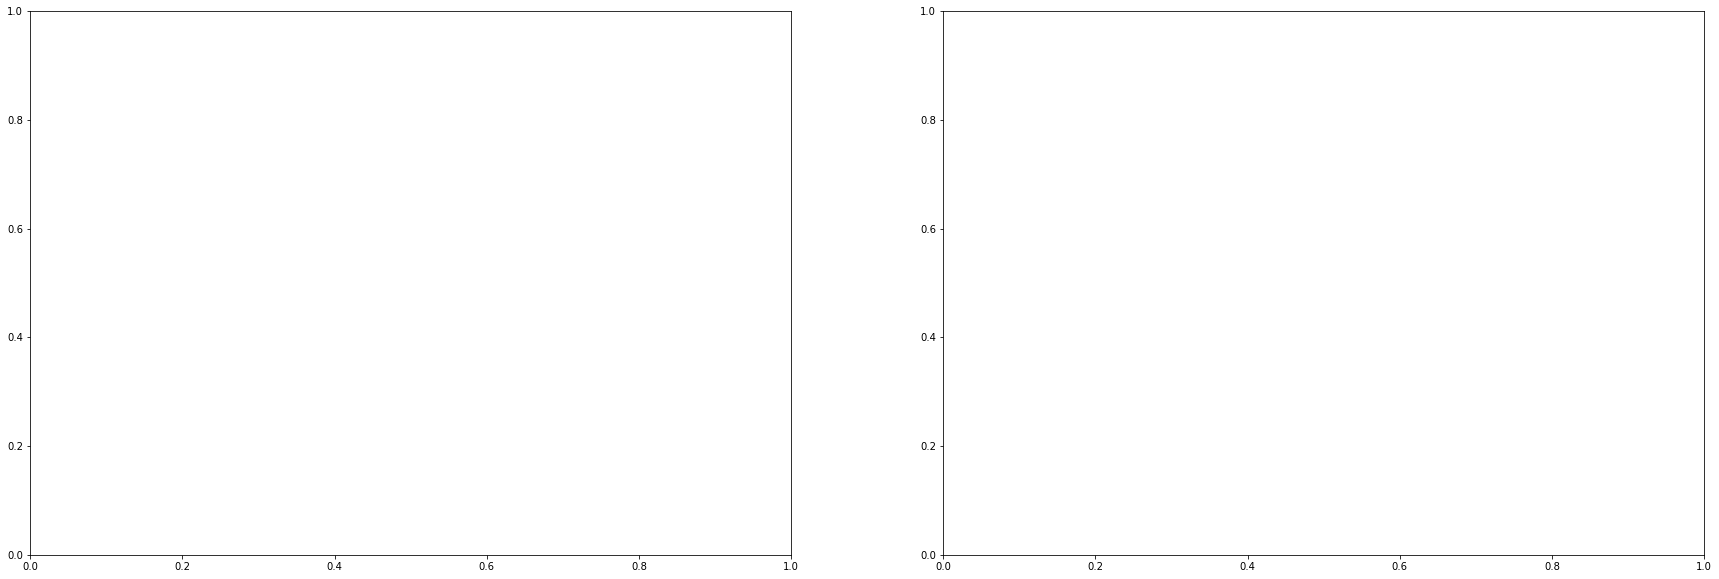

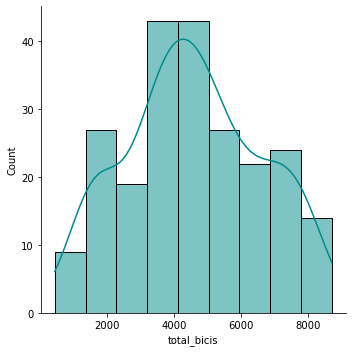

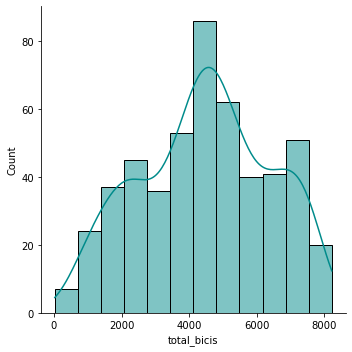

In [29]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30, 10))
sns.displot(df_no_laborables['total_bicis'], kde = True, color = "darkcyan", ax=axes[0])
sns.displot(df_laborables['total_bicis'], kde = True, color = "darkcyan", ax=axes[1])

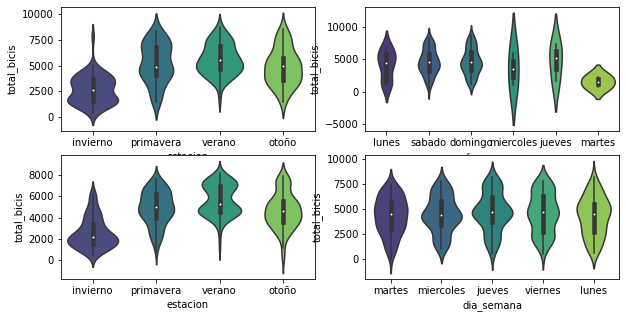

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

sns.violinplot(
    x       = 'estacion',
    y       = 'total_bicis',
    data    = df_no_laborables,
    palette = 'viridis',
    ax      = ax[0,0])
sns.violinplot(
    x       = 'dia_semana',
    y       = 'total_bicis',
    data    = df_no_laborables,
    palette = 'viridis',
    ax      = ax[0,1])

sns.violinplot(
    x       = 'estacion',
    y       = 'total_bicis',
    data    = df_laborables,
    palette = 'viridis',
    ax      = ax[1,0])
sns.violinplot(
    x       = 'dia_semana',
    y       = 'total_bicis',
    data    = df_laborables,
    palette = 'viridis',
    ax      = ax[1,1]);

<AxesSubplot:xlabel='dia_semana', ylabel='clientes_registrados'>

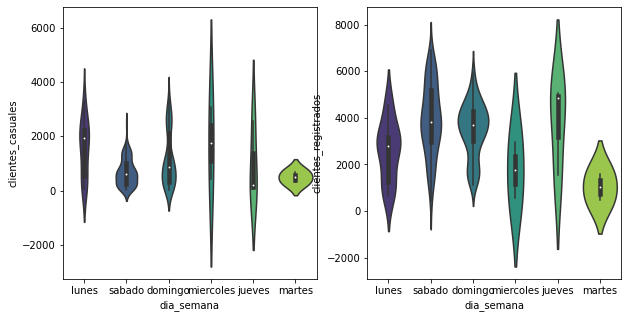

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


sns.violinplot(
    x       = 'dia_semana',
    y       = 'clientes_casuales',
    data    = df_no_laborables,
    palette = 'viridis',
    ax      = ax[0])

sns.violinplot(
    x       = 'dia_semana',
    y       = 'clientes_registrados',
    data    = df_no_laborables,
    palette = 'viridis',
    ax      = ax[1])

<AxesSubplot:xlabel='dia_semana', ylabel='clientes_registrados'>

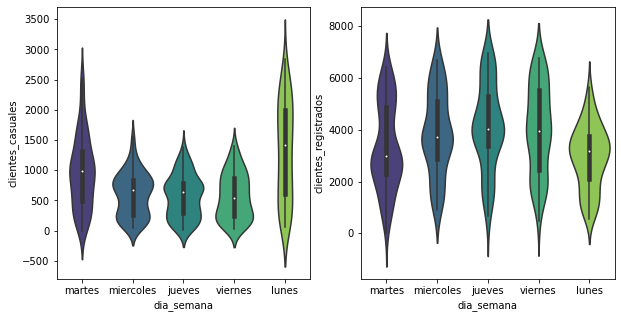

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


sns.violinplot(
    x       = 'dia_semana',
    y       = 'clientes_casuales',
    data    = df_laborables,
    palette = 'viridis',
    ax      = ax[0])


sns.violinplot(
    x       = 'dia_semana',
    y       = 'clientes_registrados',
    data    = df_laborables,
    palette = 'viridis',
    ax      = ax[1])

Las previsiones por dia de la semana, segun no laborables, las medianas, son más parecidas entre los dos grupos de clientes,salvo en los sabados, que hemos considerado no laborable, aunque lo sea, porque las correlaciones lo indicaban asi, mientras que en laborables, la prevision de registrados, casi dobla a los no casuales segun medianas(como ocurre en sabados de no laborables).Metemos sabados en laborables de nuevo.

In [33]:
df_no_laborables=cd2[(cd2['dias_festivos']!='No Festivo')|(cd2['dia_semana']=='domingo')|(cd2['dia_semana']=='sabado')]
df_no_laborables.head()

,fecha,estacion,año,mes,dia_semana,dias_festivos,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis,clientes_registrados_norm,total_bicis_norm
0,2018-01-01,invierno,0,1,lunes,New Year's Day,-0.486274,0.855582,-0.208909,331,654,985,25.573424,31.384710
5,2018-01-06,invierno,0,1,sabado,No Festivo,-0.924922,-0.514489,-0.930212,88,1518,1606,38.961519,40.074930
6,2018-01-07,invierno,0,1,domingo,No Festivo,-0.949474,-0.607702,-0.124649,148,1362,1510,36.905284,38.858718
12,2018-01-13,invierno,0,1,sabado,No Festivo,-1.048367,-0.742430,1.221408,38,1368,1406,36.986484,37.496667
13,2018-01-14,invierno,0,1,domingo,No Festivo,-1.061324,-0.421276,-0.553864,54,1367,1421,36.972963,37.696154


In [34]:
df_laborables=cd2[(cd2['dias_festivos']=='No Festivo')]
df_laborables.head()

,fecha,estacion,año,mes,dia_semana,dias_festivos,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis,clientes_registrados_norm,total_bicis_norm
1,2018-01-02,invierno,0,1,martes,No Festivo,-0.425690,0.332722,0.687550,131,670,801,25.884358,28.301943
2,2018-01-03,invierno,0,1,miercoles,No Festivo,-0.949970,-0.900337,0.685210,120,1229,1349,35.057096,36.728735
3,2018-01-04,invierno,0,1,jueves,No Festivo,-0.938563,-0.170632,-0.210435,108,1454,1562,38.131352,39.522146
4,2018-01-05,invierno,0,1,viernes,No Festivo,-0.853992,-0.901843,0.060294,82,1518,1600,38.961519,40.000000
5,2018-01-06,invierno,0,1,sabado,No Festivo,-0.924922,-0.514489,-0.930212,88,1518,1606,38.961519,40.074930


<AxesSubplot:xlabel='dia_semana', ylabel='clientes_registrados'>

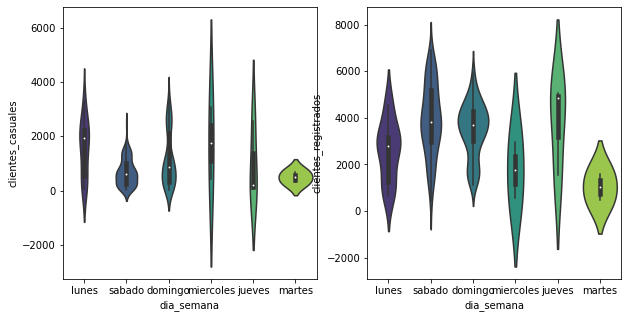

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


sns.violinplot(
    x       = 'dia_semana',
    y       = 'clientes_casuales',
    data    = df_no_laborables,
    palette = 'viridis',
    ax      = ax[0])

sns.violinplot(
    x       = 'dia_semana',
    y       = 'clientes_registrados',
    data    = df_no_laborables,
    palette = 'viridis',
    ax      = ax[1])

<AxesSubplot:xlabel='dia_semana', ylabel='clientes_registrados'>

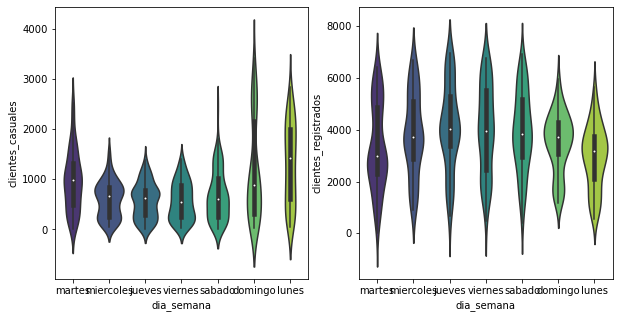

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


sns.violinplot(
    x       = 'dia_semana',
    y       = 'clientes_casuales',
    data    = df_laborables,
    palette = 'viridis',
    ax      = ax[0])


sns.violinplot(
    x       = 'dia_semana',
    y       = 'clientes_registrados',
    data    = df_laborables,
    palette = 'viridis',
    ax      = ax[1])

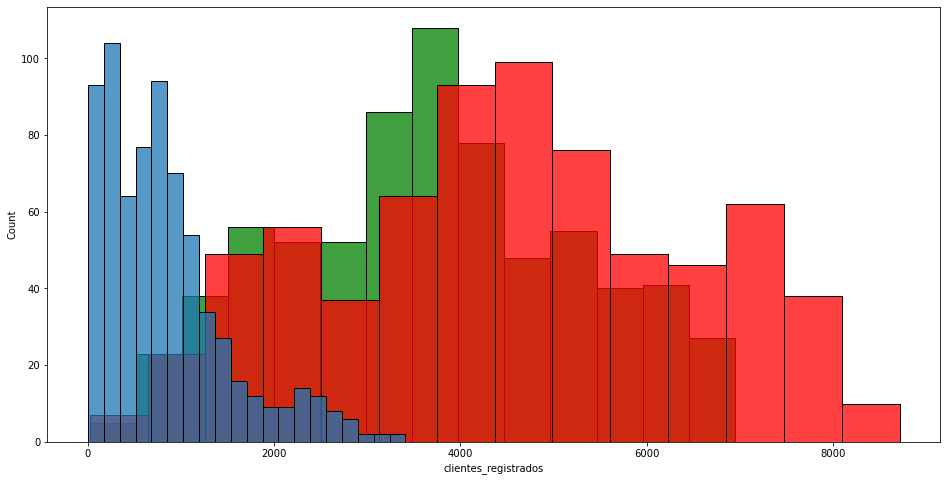

In [37]:
sns.histplot(df_laborables['clientes_registrados'], color='green')
sns.histplot(df_laborables['total_bicis'],color='red')
sns.histplot(df_laborables['clientes_casuales']);

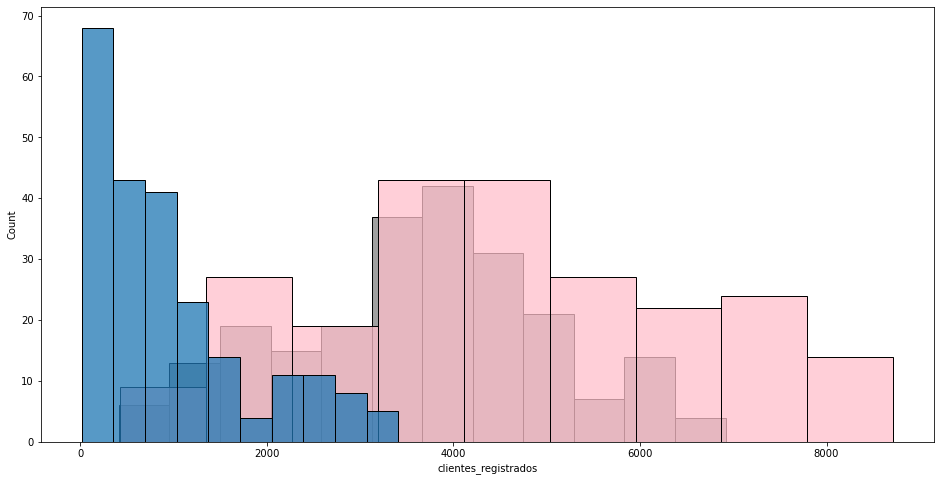

In [38]:
sns.histplot(df_no_laborables['clientes_registrados'], color='grey')
sns.histplot(df_no_laborables['total_bicis'],color='pink')
sns.histplot(df_no_laborables['clientes_casuales']);

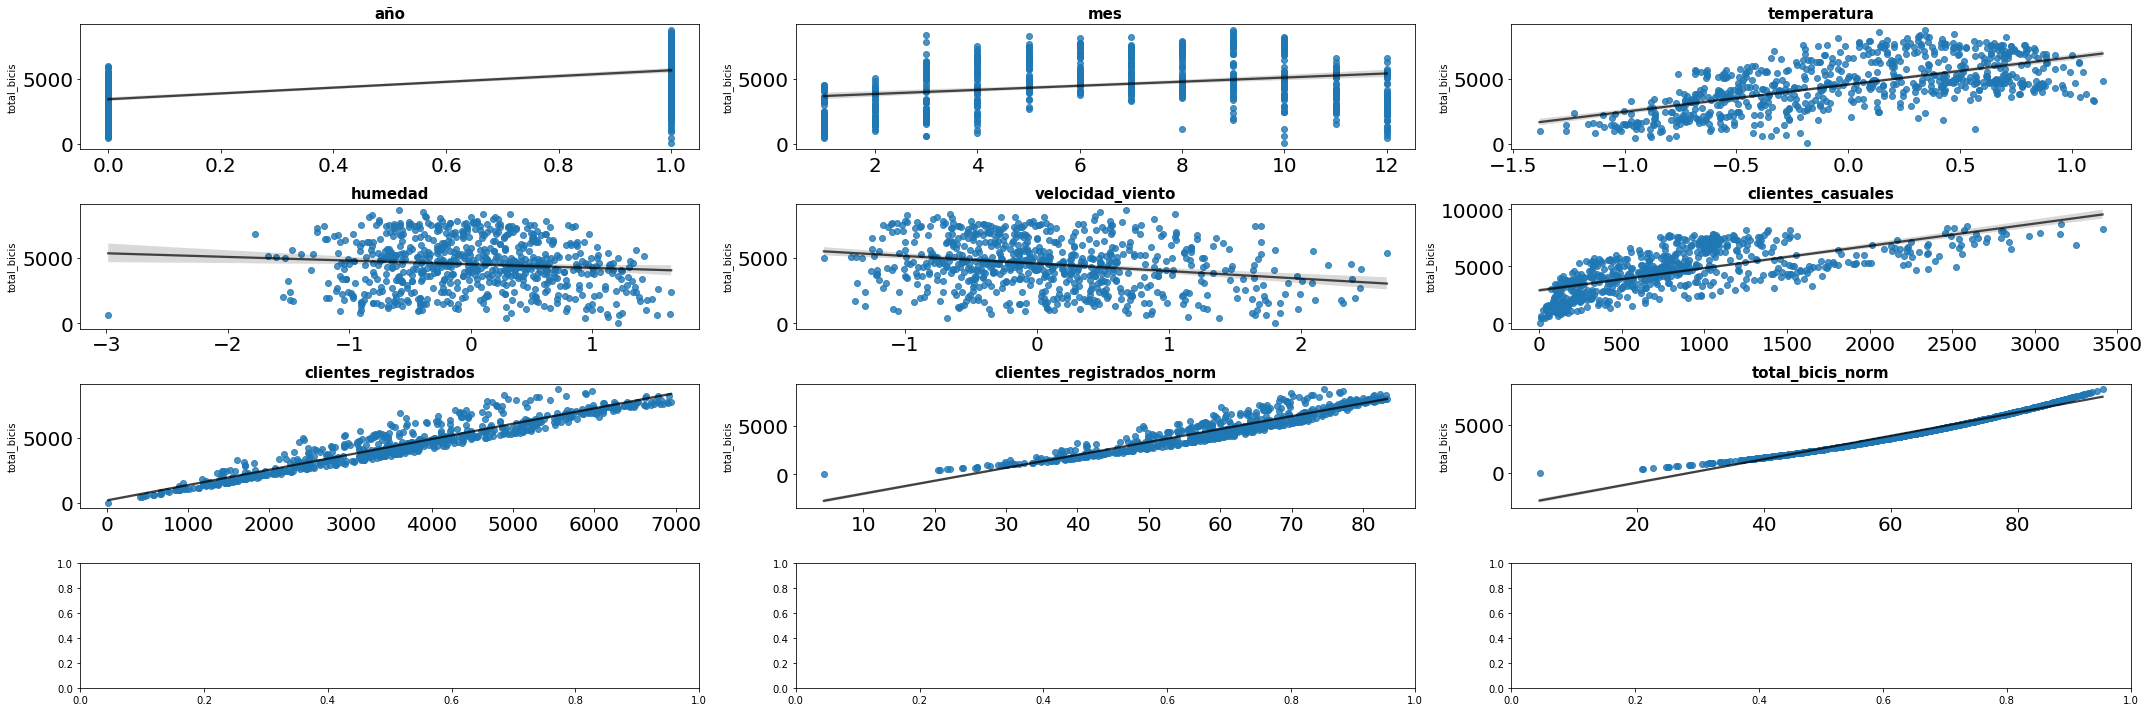

In [39]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (30, 10))

axes = axes.flat
columnas_numeric = df_laborables.select_dtypes(include = np.number).drop('total_bicis', axis=1)
columnas_numeric = columnas_numeric.columns
for i, colum in enumerate(columnas_numeric): 
    sns.regplot(
        data = df_laborables,
        x = colum,
        y = 'total_bicis',
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])
 
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")

    axes[i].tick_params(labelsize = 20)

    axes[i].set_xlabel("")
fig.tight_layout();

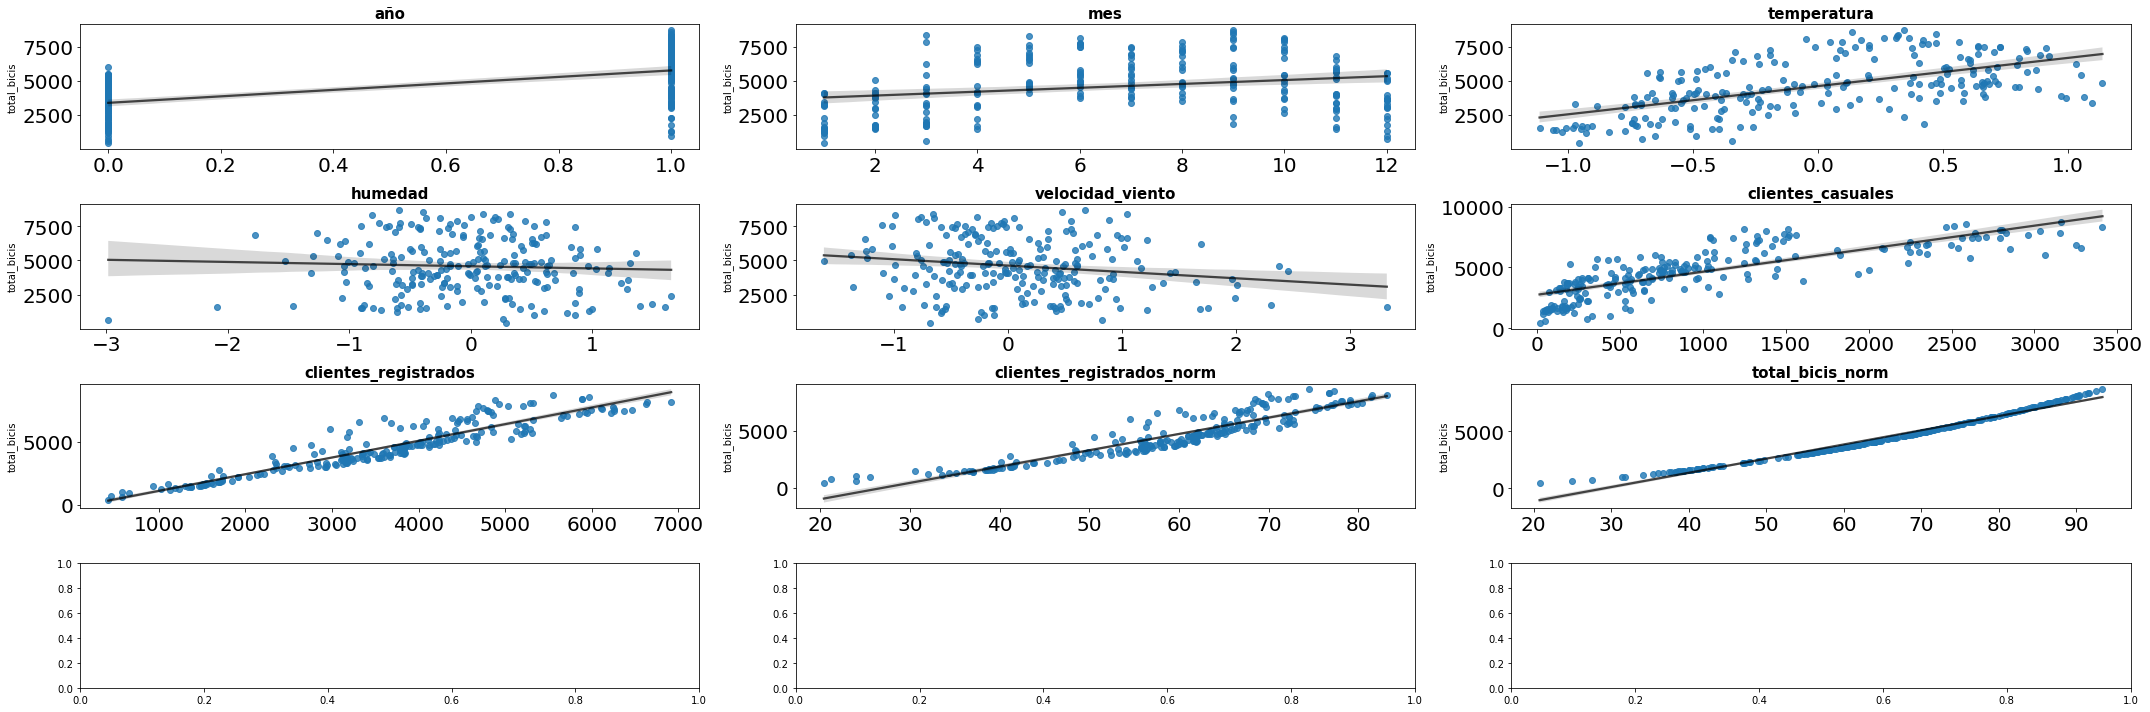

In [40]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (30, 10))

axes = axes.flat
columnas_numeric = df_no_laborables.select_dtypes(include = np.number).drop('total_bicis', axis=1)
columnas_numeric = columnas_numeric.columns
for i, colum in enumerate(columnas_numeric): 
    sns.regplot(
        data = df_no_laborables,
        x = colum,
        y = 'total_bicis',
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])
 
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")

    axes[i].tick_params(labelsize = 20)

    axes[i].set_xlabel("")
fig.tight_layout();

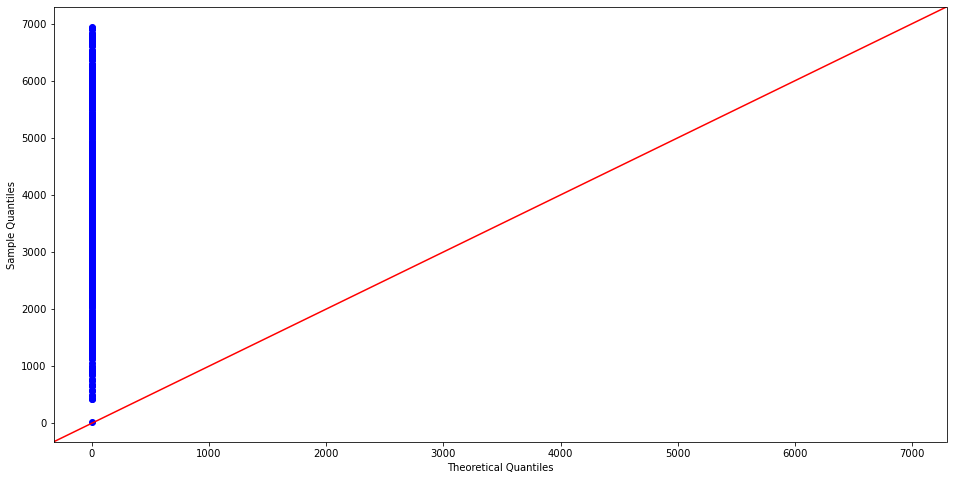

In [41]:
import statsmodels.api as sm

sm.qqplot(df_laborables['clientes_registrados'], line ='45');


In [42]:
from scipy.stats import kstest
kstest(df_laborables['clientes_registrados'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [43]:
from scipy import stats

In [44]:
df_laborables['clientes_registrados_norm'], lambda_ajustada = stats.boxcox(df_laborables['clientes_registrados'])

In [45]:
from scipy.stats import kstest
kstest(df_laborables['clientes_registrados_norm'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [46]:
df_laborables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709 entries, 1 to 729
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fecha                      709 non-null    object 
 1   estacion                   709 non-null    object 
 2   año                        709 non-null    int64  
 3   mes                        709 non-null    int64  
 4   dia_semana                 709 non-null    object 
 5   dias_festivos              709 non-null    object 
 6   temperatura                709 non-null    float64
 7   humedad                    709 non-null    float64
 8   velocidad_viento           709 non-null    float64
 9   clientes_casuales          709 non-null    int64  
 10  clientes_registrados       709 non-null    int64  
 11  total_bicis                709 non-null    int64  
 12  clientes_registrados_norm  709 non-null    float64
 13  total_bicis_norm           709 non-null    float64

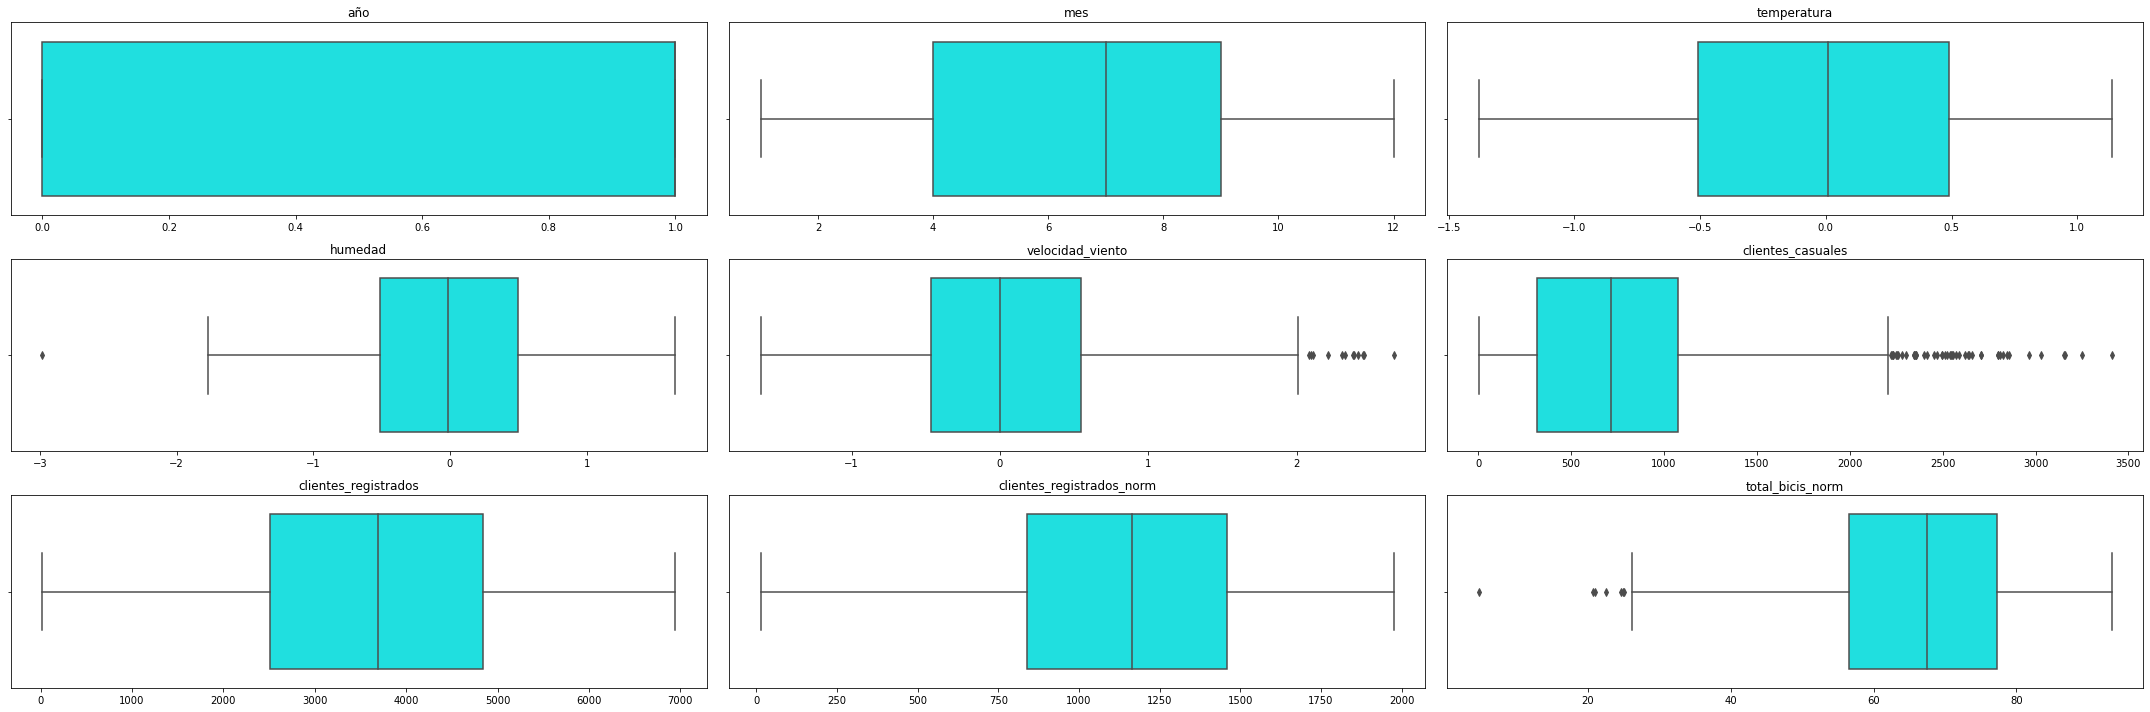

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(30,10))

categorias = df_laborables.select_dtypes(np.number).drop("total_bicis", axis = 1).columns

axes = axes.flat

for indice, cate in enumerate(categorias):

    sns.boxplot(x = df_laborables[cate], data = df_laborables, ax=axes[indice], color = "cyan"); # para trazar una línea de densidad

    axes[indice].set_title(cate)
    axes[indice].set_xlabel("")

fig.tight_layout();

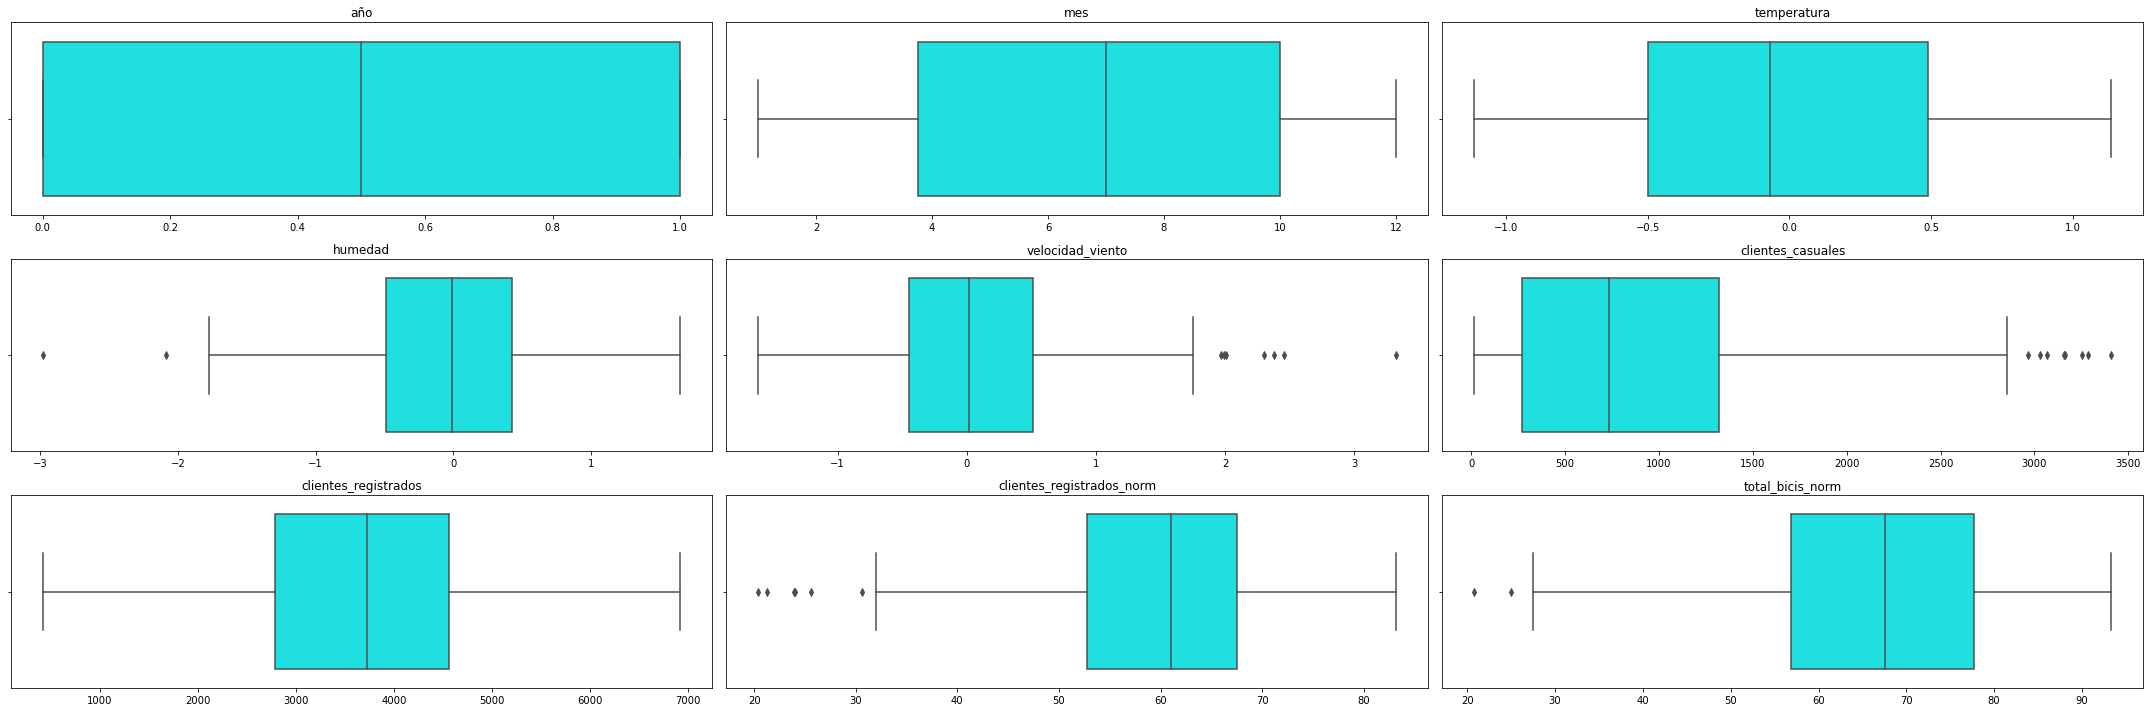

In [48]:
fig, axes = plt.subplots(3, 3, figsize=(30,10))

categorias = df_no_laborables.select_dtypes(np.number).drop("total_bicis", axis = 1).columns

axes = axes.flat

for indice, cate in enumerate(categorias):

    sns.boxplot(x = df_no_laborables[cate], data = df_no_laborables, ax=axes[indice], color = "cyan"); # para trazar una línea de densidad

    axes[indice].set_title(cate)
    axes[indice].set_xlabel("")

fig.tight_layout();

In [49]:
lluvia=df_no_laborables[(df_no_laborables['clima']=='Lluvia')]
lluvia.head(10)

KeyError: 'clima'

In [50]:
cd2['clientes_registrados'].describe()

count     730.000000
mean     3658.757534
std      1559.758728
min        20.000000
25%      2502.250000
50%      3664.500000
75%      4783.250000
max      6946.000000
Name: clientes_registrados, dtype: float64

In [51]:
cd2.loc[cd2['clientes_registrados']==6946]

,fecha,estacion,año,mes,dia_semana,dias_festivos,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis,clientes_registrados_norm,total_bicis_norm
633,2019-09-26,otoño,1,9,jueves,No Festivo,0.426145,0.021835,0.64543,787,6946,7733,83.342666,87.937478


In [52]:
cd2['clientes_casuales'].describe()

count     730.000000
mean      849.249315
std       686.479875
min         2.000000
25%       316.250000
50%       717.000000
75%      1096.500000
max      3410.000000
Name: clientes_casuales, dtype: float64

In [53]:
cd2.loc[cd2['clientes_casuales']==3410]

,fecha,estacion,año,mes,dia_semana,dias_festivos,temperatura,humedad,velocidad_viento,clientes_casuales,clientes_registrados,total_bicis,clientes_registrados_norm,total_bicis_norm
503,2019-05-19,primavera,1,5,domingo,No Festivo,0.316341,-0.809926,-0.987099,3410,4884,8294,69.885621,91.071401


In [54]:
cd2['total_bicis'].describe()

count     730.000000
mean     4508.006849
std      1936.011647
min        22.000000
25%      3169.750000
50%      4548.500000
75%      5966.000000
max      8714.000000
Name: total_bicis, dtype: float64

Lo que vemos:los registrados se ajustan perfectamente a la linea de totales, y son mayoria, tanto en laborables como no, son el minimo de alquileres. Los casuales, no son desdeñables, se distribuyen en todos los dias, pero aparecen mas en festivos, sobre todo, primavera y verano, pero en otoño no está mal tampoco.

Podemos:
- dividir dataset en ** festivos y laborables ** y la de festivos a su vez, en casuales y registrados.
- asi, ** fines de semana y festivos ** seria la suma de prevision de registrados(constante) y casuales de ese dataset.
- ** laborables ** la prevision solo de laborables (parece que igual mejoran las métricas)

O probar la prediccion de cross validate, va a ser largo de correr, obligamos al algoritmo q pase por todos los registros de 5 en 5 por ejemplo a ver si mejora la previsión. Tenemos dias puntuales, que el número de bicis se dobla. 

Más factible y precisa puede ser la primera opción